In [1]:
import sys
sys.path.append("core")
import datasets

In [2]:
if __name__ == '__main__':
    import matplotlib.pyplot as plt
    from matplotlib import gridspec
    import cv2
    import numpy as np
    def drawConcat_v1(dataTuple):
        images, flow, valid = dataTuple[0], dataTuple[1], dataTuple[2]
        images, flow = np.uint8(images.permute((0,2,3,1))),np.float32(flow.permute((1,2,0)))
        def renderFlowImg(flow, *, maxFlow=-1, style='mpi'):
            MVX_PLANE   = 0
            MVY_PLANE   = 1
            assert style in ['kitti-c++', 'mpi'], 'unknown flow rendering style: {}'.format(style)
            assert len(flow.shape) == 3
            mvx = flow[:,:,MVX_PLANE]
            mvy = flow[:,:,MVY_PLANE]
            magnitude = np.sqrt(mvx ** 2 + mvy ** 2)
            direction = np.arctan2(mvy, mvx)
            if maxFlow < 0:
                if style == 'kitti-c++':
                    maxFlow = np.fmax(magnitude.max(), 1.0)
                else:
                    # mpi style
                    maxFlow = 1.2 * max(np.fabs(mvx).max(), np.fabs(mvy).max())
                    maxFlow = np.fmax(maxFlow, 1.0)
                print('maxFlow = {:.1f}'.format(maxFlow))
            h = np.fmod(direction / (2 * np.pi) + 1.0, 1.0) * 360
            assert h.min() >= 0
            if style == 'kitti-c++':
                """KITTI C++ hsv2rgb has bug. Here tries to mimic the final result"""
                s = np.clip(magnitude * 300 / maxFlow, 0, 1.0)
                v = np.clip(magnitude * 8   / maxFlow, 0, 1.0)
            else:
                # mpi style
                n = 8
                s = np.clip(magnitude * n / maxFlow, 0, 1.0)
                v = np.clip(n - s, 0, 1.0)
            img = cv2.cvtColor(cv2.merge([h, s, v]), cv2.COLOR_HSV2RGB)
        #     img[~valid] = 0
        #     return np.uint8(img * 255)[:,:,[1,2,0]]
            return np.uint8(img * 255)

        nrow, ncol = 1, 3
        fig = plt.figure(figsize=(ncol*5, nrow*5))

        gs = gridspec.GridSpec(nrow, ncol,
             wspace=0.0, hspace=0.0, 
             top=(1.-0.5/(nrow+1))*5, bottom=5*(0.5/(nrow+1)), 
             left=(0.5/(ncol+1)), right=(1-0.5/(ncol+1))) 

        ax0 = plt.subplot(gs[0,0])
        ax1 = plt.subplot(gs[0,1])
        ax2 = plt.subplot(gs[0,2])

        ax0.imshow(images[0])
        ax0.axis("off")
        ax1.imshow(images[1])
        ax1.axis("off")
        ax2.imshow(renderFlowImg(flow))
        ax2.axis("off")
        plt.show()

In [1]:
sintel_dataset = datasets.MpiSintel(None, split='training', dstype='clean') + datasets.MpiSintel(None, split='training', dstype='final')
movi_dataset = datasets.moviSubset()
# chairs_dataset = datasets.FlyingChairs(split='training')
# autoflow_dataset = datasets.AutoFlow()

NameError: name 'datasets' is not defined

In [18]:
# flow: (2, Height, Width) 
# flow[0]: MVX   flow[1]: MVY
import torch
def getVelocityFeature(flow):
    velocityList = torch.sqrt(flow[0]**2 + flow[1]**2).reshape(-1)
    sortedVelocity = torch.sort(velocityList)[0]
    velocityLen = len(velocityList)
    quantilePoint = [sortedVelocity[velocityLen//4], sortedVelocity[velocityLen//2], sortedVelocity[3*velocityLen//4], sortedVelocity[-1]]
    velocityMAD = (velocityList - velocityList.mean()).abs().mean()
    return quantilePoint, [torch.std(velocityList)] + [velocityMAD]

In [19]:
def getDirectFeature(flow):
    directList = torch.arctan(flow[1]/(flow[0]+1e-6))
    directList[flow[0]<0] += torch.pi
    degreeDistribute = torch.histogram(directList,bins=8,range=(-torch.pi/2,torch.pi/2*3))[0]
    degreeDistribute /= degreeDistribute.sum()
    directMAD = (directList - directList.mean()).abs().mean()
    return degreeDistribute, [torch.std(directList)] + [directMAD]

In [ ]:
allFeature = []
for idx, dataTuple in enumerate(movi_dataset):
#     if idx >= 100:
#         break
    images, flow, valid = dataTuple
    velocityQuantile, velocityStd = getVelocityFeature(flow)
    directDistribute, directStd = getDirectFeature(flow)
    allFeature.append([torch.Tensor(velocityQuantile), torch.Tensor(velocityStd),torch.Tensor(directDistribute), torch.Tensor(directStd)])

In [ ]:
torch.save(allFeature,"dataLog/moviPerFlow.pth")

In [8]:
# 1.6869,  2.5938,  7.1412, 42.3159
# 6.9179, 5.3675
# 0.0626, 0.0940, 0.0774, 0.0610, 0.1985, 0.1356, 0.0908, 0.2801
# 1.8425, 1.5308

cos = torch.nn.CosineSimilarity(dim=0,eps=1e-6)
def similarity(flowFeature1, flowFeature2):
    def similarVQ(vQ1, vQ2):
        return cos(vQ1 * torch.Tensor([8,4,2,1/2]), vQ2 * torch.Tensor([8,4,2,1/2]))
    def similarVS(vS1, vS2):
        return cos(vS1, vS2)
    def similarDD(dD1, dD2):
        return cos(dD1, dD2)
    def similarDS(dS1, dS2):
        return cos(dS1, dS2)
    vQ1, vS1, dD1, dS1 = flowFeature1
    vQ2, vS2, dD2, dS2 = flowFeature2
    return (similarVQ(vQ1, vQ2)+ similarVS(vS1, vS2) + similarDD(dD1, dD2) + similarDS(dS1, dS2))/4

In [9]:
sintelFeature = torch.load("dataLog/sintelPerFlow.pth")

maxFlow = 42.9


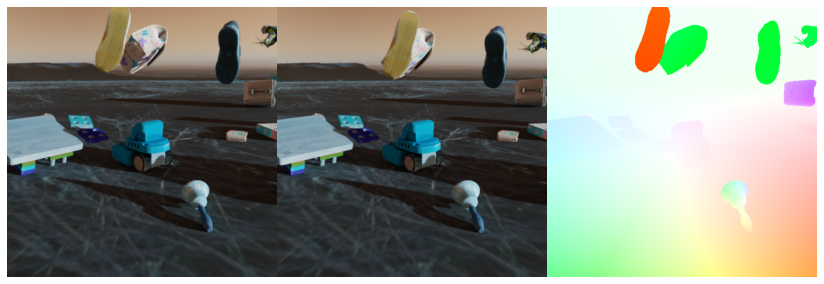

idx: tensor(1852) Similar: tensor(0.9620)
maxFlow = 286.5


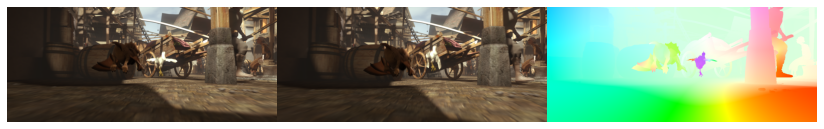

idx: tensor(811) Similar: tensor(0.9620)
maxFlow = 286.5


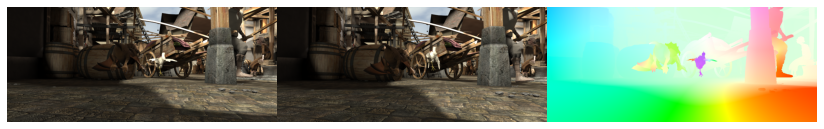

In [16]:
testIdx = 70

allSimilar = torch.zeros(len(sintelFeature))
for idx in range(len(sintelFeature)):
    allSimilar[idx] = similarity(allFeature[testIdx],sintelFeature[idx])
mostSimilar = allSimilar.topk(2)[1]

drawConcat_v1(movi_dataset[testIdx])
for idx in mostSimilar:
    print("idx:", idx, "Similar:", allSimilar[idx])
    drawConcat_v1(sintel_dataset[idx])